About the competition:


In this competition, you’ll detect wheat heads from outdoor images of wheat plants, including wheat datasets from around the globe. Using worldwide data, you will focus on a generalized solution to estimate the number and size of wheat heads. To better gauge the performance for unseen genotypes, environments, and observational conditions, the training dataset covers multiple regions. You will use more than 3,000 images from Europe (France, UK, Switzerland) and North America (Canada). The test data includes about 1,000 images from Australia, Japan, and China.

# Exploratory data analysis

Ref: https://www.kaggle.com/aleksandradeis/globalwheatdetection-eda

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# import useful tools
from glob import glob
from PIL import Image
import cv2

# import data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from bokeh.plotting import figure
from bokeh.io import output_notebook, show, output_file
from bokeh.models import ColumnDataSource, HoverTool, Panel
from bokeh.models.widgets import Tabs

# import data augmentation
import albumentations as albu

C:\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Setup the paths to train and test images
TRAIN_DIR = 'train/'
TEST_DIR = 'test/'
TRAIN_CSV_PATH = 'train.csv'

# Glob the directories and get the lists of train and test images
train_fns = glob(TRAIN_DIR + '*')
test_fns = glob(TEST_DIR + '*')

In [4]:
print('Number of train images is {}'.format(len(train_fns)))
print('Number of test images is {}'.format(len(test_fns)))

Number of train images is 3422
Number of test images is 10


**Construct dataframe with all images:**

In [5]:
# Load the dataframe with the bounding boxes
train = pd.read_csv(TRAIN_CSV_PATH)

# Create a dataframe with all train images
all_train_images = pd.DataFrame([fns.split('\\')[-1][:-4] for fns in train_fns])
all_train_images.columns=['image_id']

# Merge all train images with the bounding boxes dataframe
all_train_images = all_train_images.merge(train, on='image_id', how='left')

# replace nan values with zeros
all_train_images['bbox'] = all_train_images.bbox.fillna('[0,0,0,0]')

# split bbox column
bbox_items = all_train_images.bbox.str.split(',', expand=True)
all_train_images['bbox_xmin'] = bbox_items[0].str.strip('[ ').astype(float)
all_train_images['bbox_ymin'] = bbox_items[1].str.strip(' ').astype(float)
all_train_images['bbox_width'] = bbox_items[2].str.strip(' ').astype(float)
all_train_images['bbox_height'] = bbox_items[3].str.strip(' ]').astype(float)

print('{} images without wheat heads.'.format(len(all_train_images) - len(train)))

49 images without wheat heads.


**Plot some image examples**

In [6]:
def get_all_bboxes(df, image_id):
    image_bboxes = df[df.image_id == image_id]
    
    bboxes = []
    for _,row in image_bboxes.iterrows():
        bboxes.append((row.bbox_xmin, row.bbox_ymin, row.bbox_width, row.bbox_height))
        
    return bboxes

def plot_image_examples(df, rows=3, cols=3, title='Image examples'):
    fig, axs = plt.subplots(rows, cols, figsize=(10,10))
    for row in range(rows):
        for col in range(cols):
            idx = np.random.randint(len(df), size=1)[0]
            img_id = df.iloc[idx].image_id
            
            img = Image.open(TRAIN_DIR + img_id + '.jpg')
            axs[row, col].imshow(img)
            
            bboxes = get_all_bboxes(df, img_id)
            
            for bbox in bboxes:
                rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],linewidth=1,edgecolor='r',facecolor='none')
                axs[row, col].add_patch(rect)
            
            axs[row, col].axis('off')
            
    plt.suptitle(title)

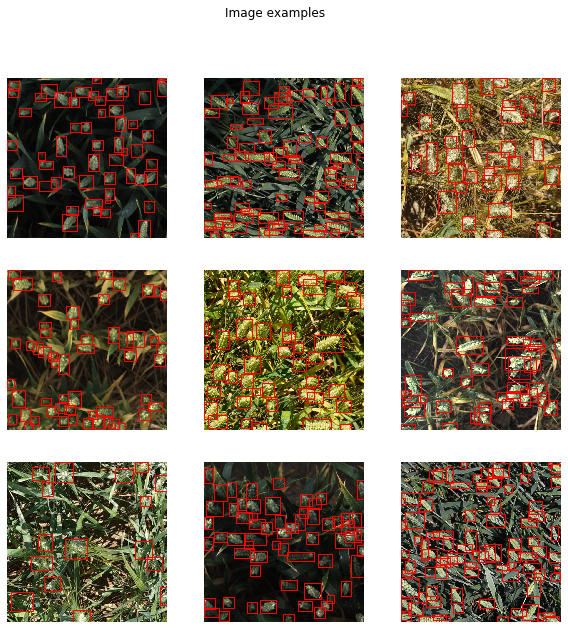

In [7]:
plot_image_examples(all_train_images)

**The number of bounding boxes (wheat spikes) per image:**

In [8]:
# compute the number of bounding boxes per train image
all_train_images['count'] = all_train_images.apply(lambda row: 1 if np.isfinite(row.width) else 0, axis=1)
train_images_count = all_train_images.groupby('image_id').sum().reset_index()

In [9]:
def hist_hover(dataframe, column, colors=["#94c8d8", "#ea5e51"], bins=30, title=''):
    hist, edges = np.histogram(dataframe[column], bins = bins)
    
    hist_df = pd.DataFrame({column: hist,
                             "left": edges[:-1],
                             "right": edges[1:]})
    hist_df["interval"] = ["%d to %d" % (left, right) for left, 
                           right in zip(hist_df["left"], hist_df["right"])]

    src = ColumnDataSource(hist_df)
    plot = figure(plot_height = 400, plot_width = 600,
          title = title,
          x_axis_label = column,
          y_axis_label = "Count")    
    plot.quad(bottom = 0, top = column,left = "left", 
        right = "right", source = src, fill_color = colors[0], 
        line_color = "#35838d", fill_alpha = 0.7,
        hover_fill_alpha = 0.7, hover_fill_color = colors[1])
        
    hover = HoverTool(tooltips = [('Interval', '@interval'),
                              ('Count', str("@" + column))])
    plot.add_tools(hover)
    
    output_notebook()
    show(plot)

In [10]:
hist_hover(train_images_count, 'count', title='Number of wheat spikes per image')

Loading BokehJS ...

**Area of bounding boxes**

In [11]:
# compute bounding box areas
all_train_images['bbox_area'] = all_train_images['bbox_width'] * all_train_images['bbox_height']

In [12]:
# plot a histogram of bounding box areas
hist_hover(all_train_images, 'bbox_area', title='Area of a single bounding box')

Loading BokehJS ...

In [13]:
# compute the total bounding boxes area per image
area_per_image = all_train_images.groupby(by='image_id').sum().reset_index()

# compute the percentage of the image area covered by bounding boxes
area_per_image_percentage = area_per_image.copy()
area_per_image_percentage['bbox_area'] = area_per_image_percentage['bbox_area'] / (1024*1024) * 100

In [14]:
hist_hover(area_per_image_percentage, 'bbox_area', title='Percentage of image area covered by bounding boxes')

Loading BokehJS ...

Thoughts on Data Augmentation
Data augmentation is critical in this competition, because there is a relatively small training set. Data augmentation will allow to build robust models under given circumstances. What augmentations/filers might work:

flipping images horizontally and vertically, because the orientation of original images is different;
crop-resize, because we can see spikes at different zoom levels;
different filters to adjust the lighting conditions. I suggest looking at this competition for example.
What to do with caution:

rotation might not work, because rotation messes up the bounding boxes.

# EfficientDet

Ref: https://www.kaggle.com/shonenkov/training-efficientdet

In [1]:
#!pip install torch==1.5.0+cpu torchvision==0.6.0+cpu -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Attempting uninstall: torch
    Found existing installation: torch 1.2.0+cu92
    Uninstalling torch-1.2.0+cu92:
      Successfully uninstalled torch-1.2.0+cu92
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.4.0+cu92
    Uninstalling torchvision-0.4.0+cu92:
      Successfully uninstalled torchvision-0.4.0+cu92


In [4]:
#!pip install git+https://github.com/philferriere/cocoapi.git#egg=pycocotools^&subdirectory=PythonAPI

  Cloning https://github.com/philferriere/cocoapi.git to c:\users\メロデ~1\appdata\local\temp\pip-install-m9569gm4\pycocotools
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-win_amd64.whl size=87377 sha256=c3024b35f5859b97085c8577271afc12a938a2ef6417cea247e79f625de276c8
  Stored in directory: C:\Users\メロデ~1\AppData\Local\Temp\pip-ephem-wheel-cache-5h_9s54q\wheels\6b\c6\c5\cb6da4cb793a6cb1ab91f6578d76c42686422127eb4dbcea94
Successfully built pycocotools


In [5]:
import sys
#sys.path.insert(0, "../input/timm-efficientdet-pytorch")
#sys.path.insert(0, "../input/omegaconf")

import torch
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from glob import glob

SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [7]:
marking = pd.read_csv('train.csv')

bboxs = np.stack(marking['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    marking[column] = bboxs[:,i]
marking.drop(columns=['bbox'], inplace=True)

Data splitting:

In [8]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

df_folds = marking[['image_id']].copy()
df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby('image_id').count()
df_folds.loc[:, 'source'] = marking[['image_id', 'source']].groupby('image_id').min()['source']
df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['source'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
)
df_folds.loc[:, 'fold'] = 0

for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


**Albumentations**

In [9]:
def get_train_transforms():
    return A.Compose(
        [
            A.RandomSizedCrop(min_max_height=(800, 800), height=1024, width=1024, p=0.5),
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            A.ToGray(p=0.01),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Resize(height=512, width=512, p=1),
            A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

**Dataset**

In [15]:
TRAIN_ROOT_PATH = 'train'

class DatasetRetriever(Dataset):

    def __init__(self, marking, image_ids, transforms=None, test=False):
        super().__init__()

        self.image_ids = image_ids
        self.marking = marking
        self.transforms = transforms
        self.test = test

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        
        if self.test or random.random() > 0.5:
            image, boxes = self.load_image_and_boxes(index)
        else:
            image, boxes = self.load_cutmix_image_and_boxes(index)

        # there is only one class
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])

        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  #yxyx: be warning
                    break

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{TRAIN_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        records = self.marking[self.marking['image_id'] == image_id]
        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        return image, boxes

    def load_cutmix_image_and_boxes(self, index, imsize=1024):
        """ 
        This implementation of cutmix author:  https://www.kaggle.com/nvnnghia 
        Refactoring and adaptation: https://www.kaggle.com/shonenkov
        """
        w, h = imsize, imsize
        s = imsize // 2
    
        xc, yc = [int(random.uniform(imsize * 0.25, imsize * 0.75)) for _ in range(2)]  # center x, y
        indexes = [index] + [random.randint(0, self.image_ids.shape[0] - 1) for _ in range(3)]

        result_image = np.full((imsize, imsize, 3), 1, dtype=np.float32)
        result_boxes = []

        for i, index in enumerate(indexes):
            image, boxes = self.load_image_and_boxes(index)
            if i == 0:
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)
            result_image[y1a:y2a, x1a:x2a] = image[y1b:y2b, x1b:x2b]
            padw = x1a - x1b
            padh = y1a - y1b

            boxes[:, 0] += padw
            boxes[:, 1] += padh
            boxes[:, 2] += padw
            boxes[:, 3] += padh

            result_boxes.append(boxes)

        result_boxes = np.concatenate(result_boxes, 0)
        np.clip(result_boxes[:, 0:], 0, 2 * s, out=result_boxes[:, 0:])
        result_boxes = result_boxes.astype(np.int32)
        result_boxes = result_boxes[np.where((result_boxes[:,2]-result_boxes[:,0])*(result_boxes[:,3]-result_boxes[:,1]) > 0)]
        return result_image, result_boxes

In [16]:
fold_number = 0

train_dataset = DatasetRetriever(
    image_ids=df_folds[df_folds['fold'] != fold_number].index.values,
    marking=marking,
    transforms=get_train_transforms(),
    test=False,
)

validation_dataset = DatasetRetriever(
    image_ids=df_folds[df_folds['fold'] == fold_number].index.values,
    marking=marking,
    transforms=get_valid_transforms(),
    test=True,
)

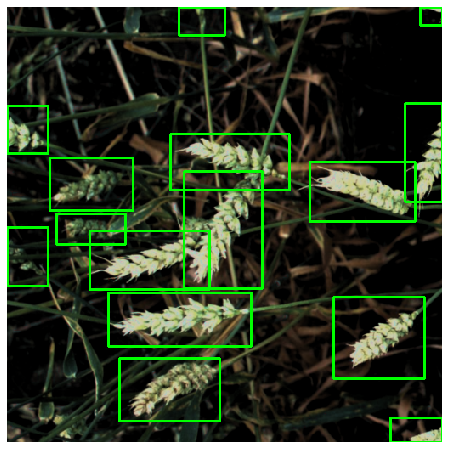

In [17]:
image, target, image_id = train_dataset[1]
boxes = target['boxes'].cpu().numpy().astype(np.int32)

numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 2)
    
ax.set_axis_off()
ax.imshow(numpy_image);

**Fitter**

In [20]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [43]:
import warnings

warnings.filterwarnings("ignore")

class Fitter:
    
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0

        self.base_dir = f'./{config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
        
        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10**5

        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ] 

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f'Fitter prepared. Device is {self.device}')

    def fit(self, train_loader, validation_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss = self.train_one_epoch(train_loader)

            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint.bin')

            t = time.time()
            summary_loss = self.validation(validation_loader)

            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            if summary_loss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_loss.avg
                self.model.eval()
                self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.bin'))[:-3]:
                    os.remove(path)

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)

            self.epoch += 1

    def validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step}/{len(val_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            with torch.no_grad():
                images = torch.stack(images)
                batch_size = images.shape[0]
                images = images.to(self.device).float()
                '''
                boxes = [target['boxes'].to(self.device).float() for target in targets]
                labels = [target['labels'].to(self.device).float() for target in targets]

                loss, _, _ = self.model(images, boxes, labels)
                '''
                boxes = [target['boxes'].to(self.device).float() for target in targets]
                labels = [target['labels'].to(self.device).float() for target in targets]

                target_res = {}
                target_res['bbox'] = boxes
                target_res['cls'] = labels 
                target_res["img_scale"] = torch.tensor([1.0] * batch_size, dtype=torch.float).to(self.device)
                target_res["img_size"] = torch.tensor([images[0].shape[-2:]] * batch_size, dtype=torch.float).to(self.device)

                outputs = self.model(images, target_res)
                loss = outputs['loss']

                summary_loss.update(loss.detach().item(), batch_size)

        return summary_loss

    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            
            images = torch.stack(images)
            images = images.to(self.device).float()
            batch_size = images.shape[0]
            '''
            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]

            self.optimizer.zero_grad()
            
            loss, _, _ = self.model(images, boxes, labels)
            
            loss.backward()
            '''
            target_res = {}
            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]
            target_res['bbox'] = boxes
            target_res['cls'] = labels 
            self.optimizer.zero_grad()

            # targets
            outputs = self.model(images, target_res)
            loss = outputs['loss']

            loss.backward()

            summary_loss.update(loss.detach().item(), batch_size)

            self.optimizer.step()

            if self.config.step_scheduler:
                self.scheduler.step()

        return summary_loss
    
    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_loss': self.best_summary_loss,
            'epoch': self.epoch,
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1
        
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

In [44]:
class TrainGlobalConfig:
    num_workers = 2
    batch_size = 4 
    n_epochs = 3 # n_epochs = 40
    lr = 0.0002

    folder = 'effdet5-cutmix-augmix'

    # -------------------
    verbose = True
    verbose_step = 1
    # -------------------

    # --------------------
    step_scheduler = False  # do scheduler.step after optimizer.step
    validation_scheduler = True  # do scheduler.step after validation stage loss

#     SchedulerClass = torch.optim.lr_scheduler.OneCycleLR
#     scheduler_params = dict(
#         max_lr=0.001,
#         epochs=n_epochs,
#         steps_per_epoch=int(len(train_dataset) / batch_size),
#         pct_start=0.1,
#         anneal_strategy='cos', 
#         final_div_factor=10**5
#     )
    
    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
        mode='min',
        factor=0.5,
        patience=1,
        verbose=False, 
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0, 
        min_lr=1e-8,
        eps=1e-08
    )
    # --------------------

In [45]:
def collate_fn(batch):
    return tuple(zip(*batch))

def run_training():
    device = torch.device('cpu')
    net.to(device)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=RandomSampler(train_dataset),
        pin_memory=False,
        drop_last=True,
        num_workers=0,#TrainGlobalConfig.num_workers
        collate_fn=collate_fn,
    )
    val_loader = torch.utils.data.DataLoader(
        validation_dataset, 
        batch_size=TrainGlobalConfig.batch_size,
        num_workers=TrainGlobalConfig.num_workers,
        shuffle=False,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
        collate_fn=collate_fn,
    )

    fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
    fitter.fit(train_loader, val_loader)

In [46]:
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet

def get_net():
    config = get_efficientdet_config('tf_efficientdet_d5')
    net = EfficientDet(config, pretrained_backbone=False)
    checkpoint = torch.load('effdet/efficientdet_d5-ef44aea8.pth')
    net.load_state_dict(checkpoint)
    config.num_classes = 1
    config.image_size = 512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
    return DetBenchTrain(net, config)

net = get_net()

In [47]:
run_training()

Fitter prepared. Device is cpu

2020-09-24T15:00:52.133351
LR: 0.0002


IndexError: index out of range in self

# YoloV5 train and Pseudo Labeling

Train: https://www.kaggle.com/orkatz2/yolov5-train

Pseudo labeling: https://www.kaggle.com/nvnnghia/yolov5-pseudo-labeling

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm.auto import tqdm
import shutil as sh

**Getting Yolov5 repo**

https://github.com/ultralytics/yolov5/tree/v1.0

## Train

In [2]:
df = pd.read_csv('train.csv')
bboxs = np.stack(df['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    df[column] = bboxs[:,i]
df.drop(columns=['bbox'], inplace=True)
df['x_center'] = df['x'] + df['w']/2
df['y_center'] = df['y'] + df['h']/2
df['classes'] = 0
from tqdm.auto import tqdm
import shutil as sh
df = df[['image_id','x', 'y', 'w', 'h','x_center','y_center','classes']]

In [3]:
df.head()

,image_id,x,y,w,h,x_center,y_center,classes
0,b6ab77fd7,834.0,222.0,56.0,36.0,862.0,240.0,0
1,b6ab77fd7,226.0,548.0,130.0,58.0,291.0,577.0,0
2,b6ab77fd7,377.0,504.0,74.0,160.0,414.0,584.0,0
3,b6ab77fd7,834.0,95.0,109.0,107.0,888.5,148.5,0
4,b6ab77fd7,26.0,144.0,124.0,117.0,88.0,202.5,0


In [4]:
index = list(set(df.image_id))

In [5]:
source = 'train'
if True:
    for fold in [0]:
        val_index = index[len(index)*fold//5:len(index)*(fold+1)//5]
        for name,mini in tqdm(df.groupby('image_id')):
            if name in val_index:
                path2save = 'val2017/'
            else:
                path2save = 'train2017/'
            if not os.path.exists('convertor/fold{}/labels/'.format(fold)+path2save):
                os.makedirs('convertor/fold{}/labels/'.format(fold)+path2save)
            with open('convertor/fold{}/labels/'.format(fold)+path2save+name+".txt", 'w+') as f:
                row = mini[['classes','x_center','y_center','w','h']].astype(float).values
                row = row/1024
                row = row.astype(str)
                for j in range(len(row)):
                    text = ' '.join(row[j])
                    f.write(text)
                    f.write("\n")
            if not os.path.exists('convertor/fold{}/images/{}'.format(fold,path2save)):
                os.makedirs('convertor/fold{}/images/{}'.format(fold,path2save))
            sh.copy("{}/{}.jpg".format(source,name),'convertor/fold{}/images/{}/{}.jpg'.format(fold,path2save,name))

In [ ]:
!python yolov5/train.py --img 1024 --batch 2 --epochs 1 --data wheat0.yaml --cfg yolov5x.yaml --name yolov5x_fold0

## Pseudo labeling

**Convert train data to yolov5 format**

In [11]:
def convertTrainLabel():
    df = pd.read_csv('train.csv')
    bboxs = np.stack(df['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
    for i, column in enumerate(['x', 'y', 'w', 'h']):
        df[column] = bboxs[:,i]
    df.drop(columns=['bbox'], inplace=True)
    df['x_center'] = df['x'] + df['w']/2
    df['y_center'] = df['y'] + df['h']/2
    df['classes'] = 0
    from tqdm.auto import tqdm
    import shutil as sh
    df = df[['image_id','x', 'y', 'w', 'h','x_center','y_center','classes']]
    
    index = list(set(df.image_id))
    
    source = 'train'
    if True:
        for fold in [0]:
            val_index = index[len(index)*fold//5:len(index)*(fold+1)//5]
            for name,mini in tqdm(df.groupby('image_id')):
                if name in val_index:
                    path2save = 'val2017/'
                else:
                    path2save = 'train2017/'
                if not os.path.exists('convertor/fold{}/labels/'.format(fold)+path2save):
                    os.makedirs('convertor/fold{}/labels/'.format(fold)+path2save)
                with open('convertor/fold{}/labels/'.format(fold)+path2save+name+".txt", 'w+') as f:
                    row = mini[['classes','x_center','y_center','w','h']].astype(float).values
                    row = row/1024
                    row = row.astype(str)
                    for j in range(len(row)):
                        text = ' '.join(row[j])
                        f.write(text)
                        f.write("\n")
                if not os.path.exists('convertor/fold{}/images/{}'.format(fold,path2save)):
                    os.makedirs('convertor/fold{}/images/{}'.format(fold,path2save))
                sh.copy("{}/{}.jpg".format(source,name),'convertor/fold{}/images/{}/{}.jpg'.format(fold,path2save,name))

Some useful functions:

In [12]:
from ensemble_boxes import *
def run_wbf(boxes, scores, image_size=1023, iou_thr=0.5, skip_box_thr=0.7, weights=None):
    #boxes = [prediction[image_index]['boxes'].data.cpu().numpy()/(image_size-1) for prediction in predictions]
    #scores = [prediction[image_index]['scores'].data.cpu().numpy() for prediction in predictions]
    labels = [np.zeros(score.shape[0]) for score in scores]
    boxes = [box/(image_size) for box in boxes]
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    #boxes, scores, labels = nms(boxes, scores, labels, weights=[1,1,1,1,1], iou_thr=0.5)
    boxes = boxes*(image_size)
    return boxes, scores, labels

def TTAImage(image, index):
    image1 = image.copy()
    if index==0: 
        rotated_image = cv2.rotate(image1, cv2.ROTATE_90_CLOCKWISE)
        return rotated_image
    elif index==1:
        rotated_image2 = cv2.rotate(image1, cv2.ROTATE_90_CLOCKWISE)
        rotated_image2 = cv2.rotate(rotated_image2, cv2.ROTATE_90_CLOCKWISE)
        return rotated_image2
    elif index==2:
        rotated_image3 = cv2.rotate(image1, cv2.ROTATE_90_CLOCKWISE)
        rotated_image3 = cv2.rotate(rotated_image3, cv2.ROTATE_90_CLOCKWISE)
        rotated_image3 = cv2.rotate(rotated_image3, cv2.ROTATE_90_CLOCKWISE)
        return rotated_image3
    elif index == 3:
        return image1
    
def rotBoxes90(boxes, im_w, im_h):
    ret_boxes =[]
    for box in boxes:
        x1, y1, x2, y2 = box
        x1, y1, x2, y2 = x1-im_w//2, im_h//2 - y1, x2-im_w//2, im_h//2 - y2
        x1, y1, x2, y2 = y1, -x1, y2, -x2
        x1, y1, x2, y2 = int(x1+im_w//2), int(im_h//2 - y1), int(x2+im_w//2), int(im_h//2 - y2)
        x1a, y1a, x2a, y2a = min(x1, x2), min(y1, y2), max(x1, x2), max(y1, y2)
        ret_boxes.append([x1a, y1a, x2a, y2a])
    return np.array(ret_boxes)

def detect1Image(im0, imgsz, model, device, conf_thres, iou_thres):
    img = letterbox(im0, new_shape=imgsz)[0]
    # Convert
    img = img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to 3x416x416
    img = np.ascontiguousarray(img)


    img = torch.from_numpy(img).to(device)
    img =  img.float()  # uint8 to fp16/32
    img /= 255.0   
    if img.ndimension() == 3:
        img = img.unsqueeze(0)

    # Inference
    pred = model(img, augment=False)[0]

    # Apply NMS
    pred = non_max_suppression(pred, conf_thres, iou_thres)

    boxes = []
    scores = []
    for i, det in enumerate(pred):  # detections per image
        # save_path = 'draw/' + image_id + '.jpg'
        if det is not None and len(det):
            # Rescale boxes from img_size to im0 size
            det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()

            # Write results
            for *xyxy, conf, cls in det:
                boxes.append([int(xyxy[0]), int(xyxy[1]), int(xyxy[2]), int(xyxy[3])])
                scores.append(conf)

    return np.array(boxes), np.array(scores) 

**Make pseudo labels for Yolov5**

In [13]:
from utils.datasets import *
from utils.utils import *

def makePseudolabel():
    source = 'test/'
    weights = 'yolov5/bestv4.pt'
    imgsz = 1024
    conf_thres = 0.5
    iou_thres = 0.6
    is_TTA = True
    
    imagenames =  os.listdir(source)
    
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # Load model
    model = torch.load(weights, map_location=device)['model'].float()  # load to FP32
    model.to(device).eval()
    
    dataset = LoadImages(source, img_size=imgsz)

    path2save = 'train2017/'
    if not os.path.exists('convertor/fold0/labels/'+path2save):
        os.makedirs('convertor/fold0/labels/'+path2save)
    if not os.path.exists('convertor/fold0/images/{}'.format(path2save)):
        os.makedirs('convertor/fold0/images/{}'.format(path2save))
            
    for name in imagenames:
        image_id = name.split('.')[0]
        im01 = cv2.imread('%s/%s.jpg'%(source,image_id))  # BGR
        if im01.shape[0]!=1024 or im01.shape[1]!=1024:
            continue
        assert im01 is not None, 'Image Not Found '
        # Padded resize
        im_w, im_h = im01.shape[:2]
        if is_TTA:
            enboxes = []
            enscores = []
            for i in range(4):
                im0 = TTAImage(im01, i)
                boxes, scores = detect1Image(im0, imgsz, model, device, conf_thres, iou_thres)
                for _ in range(3-i):
                    boxes = rotBoxes90(boxes, im_w, im_h)
                    
                enboxes.append(boxes)
                enscores.append(scores) 

            boxes, scores, labels = run_wbf(enboxes, enscores, image_size = im_w, iou_thr=0.6, skip_box_thr=0.43)
            boxes = boxes.astype(np.int32).clip(min=0, max=im_w)
        else:
            boxes, scores = detect1Image(im01, imgsz, model, device, conf_thres, iou_thres)

        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        
        boxes = boxes[scores >= 0.05].astype(np.int32)
        scores = scores[scores >=float(0.05)]
        
        lineo = ''
        for box in boxes:
            x1, y1, w, h = box
            xc, yc, w, h = (x1+w/2)/1024, (y1+h/2)/1024, w/1024, h/1024
            lineo += '0 %f %f %f %f\n'%(xc, yc, w, h)
            
        fileo = open('convertor/fold0/labels/'+path2save+image_id+".txt", 'w+')
        fileo.write(lineo)
        fileo.close()
        sh.copy("test/{}.jpg".format(image_id),'convertor/fold0/images/{}/{}.jpg'.format(path2save,image_id))

In [14]:
convertTrainLabel()

In [ ]:
makePseudolabel()

**Retrain yolov5 with pseudo data**

In [ ]:
if len(os.listdir('../input/global-wheat-detection/test/'))<11:
    pass
    #!python train.py --img 1024 --batch 4 --epochs 1 --data ../input/configyolo5/wheat0.yaml --cfg ../input/yolov5/v5/v5/models/yolov5x.yaml  --weights ../input/yolov5/bestv4.pt   
else:
    !python train.py --img 1024 --batch 4 --epochs 10 --data ../input/configyolo5/wheat0.yaml --cfg ../input/yolov5/v5/v5/models/yolov5x.yaml --weights ../input/yolov5/bestv4.pt
    
    
!rm -rf convertor

In [ ]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

**Final prediction**

In [ ]:
def detect():
    source = '../input/global-wheat-detection/test/'
    weights = 'weights/best.pt'
    if not os.path.exists(weights):
        weights = '../input/yolov5/bestv4.pt'
    imgsz = 1024
    conf_thres = 0.5
    iou_thres = 0.6
    is_TTA = True
    
    imagenames =  os.listdir(source)
    
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # Load model
    model = torch.load(weights, map_location=device)['model'].float()  # load to FP32
    model.to(device).eval()
    
    dataset = LoadImages(source, img_size=imgsz)

    results = []
    fig, ax = plt.subplots(5, 2, figsize=(30, 70))
    count = 0
    # img = torch.zeros((1, 3, imgsz, imgsz), device=device)  # init img
    #for path, img, im0s, _ in dataset:
    for name in imagenames:
        image_id = name.split('.')[0]
        im01 = cv2.imread('%s/%s.jpg'%(source,image_id))  # BGR
        assert im01 is not None, 'Image Not Found '
        # Padded resize
        im_w, im_h = im01.shape[:2]
        if is_TTA:
            enboxes = []
            enscores = []
            for i in range(4):
                im0 = TTAImage(im01, i)
                boxes, scores = detect1Image(im0, imgsz, model, device, conf_thres, iou_thres)
                for _ in range(3-i):
                    boxes = rotBoxes90(boxes, im_w, im_h)
                    
                if 1: #i<3:
                    enboxes.append(boxes)
                    enscores.append(scores) 
            boxes, scores = detect1Image(im01, imgsz, model, device, conf_thres, iou_thres)
            enboxes.append(boxes)
            enscores.append(scores)

            boxes, scores, labels = run_wbf(enboxes, enscores, image_size = im_w, iou_thr=0.6, skip_box_thr=0.5)
            boxes = boxes.astype(np.int32).clip(min=0, max=im_w)
        else:
            boxes, scores = detect1Image(im01, imgsz, model, device, conf_thres, iou_thres)

        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        
        boxes = boxes[scores >= 0.05].astype(np.int32)
        scores = scores[scores >=float(0.05)]
        if count<10:
            #sample = image.permute(1,2,0).cpu().numpy()
            for box, score in zip(boxes,scores):
                cv2.rectangle(im0,
                              (box[0], box[1]),
                              (box[2]+box[0], box[3]+box[1]),
                              (220, 0, 0), 2)
                cv2.putText(im0, '%.2f'%(score), (box[0], box[1]), cv2.FONT_HERSHEY_SIMPLEX ,  
                   0.5, (255,255,255), 2, cv2.LINE_AA)
            ax[count%5][count//5].imshow(im0)
            count+=1
            
        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }

        results.append(result)
    return results

In [ ]:
results = detect()
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.to_csv('submission.csv', index=False)
test_df.head()